In [28]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math


def filtering_2d(image, kernel, sobel=False):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate the output dimensions
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # Initialize the output matrix
    output = np.zeros((output_height, output_width))

    # Apply convolution (slide the kernel over the image)
    for i in range(output_height):
        for j in range(output_width):
            # Element-wise multiplication and sum
            total_sum = np.sum(
                image[i : i + kernel_height, j : j + kernel_width] * kernel
            )
            output[i, j] = total_sum if sobel == False else abs(total_sum)

    return output


def get_grad_mag(matrix_1, matrix_2):
    cols, rows = matrix_1.shape
    output = np.zeros((cols, rows))

    for i in range(cols):
        for j in range(rows):
            pixel_1 = matrix_1[i, j]
            pixel_2 = matrix_2[i, j]
            output[i, j] = math.sqrt(pixel_1**2 + pixel_2**2)

    return output


def get_grad_angle(matrix_1, matrix_2):
    cols, rows = matrix_1.shape
    output = np.zeros((cols, rows))

    for i in range(cols):
        for j in range(rows):
            pixel_1 = matrix_1[i, j]
            pixel_2 = matrix_2[i, j]
            output[i, j] = math.degrees(math.atan2(pixel_2, pixel_1))

    return output


def quantized_angle(gradient_angles):
    height, width = gradient_angles.shape
    gradient_angles = gradient_angles % 180
    result = np.zeros((height, width))

    for h in range(height):
        for w in range(width):
            angle = gradient_angles[h, w]

            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                result[h, w] = 0
            elif 22.5 <= angle < 67.5:
                result[h, w] = 45
            elif 67.5 <= angle < 112.5:
                result[h, w] = 90
            elif 112.5 <= angle < 157.5:
                result[h, w] = 135

    return result


def non_max_suppression(magnitude, angle):
    height, width = magnitude.shape
    suppressed = np.copy(magnitude)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            angle_val = angle[i, j]
            if angle_val == 0:
                if (
                    magnitude[i, j] < magnitude[i, j - 1]
                    or magnitude[i, j] < magnitude[i, j + 1]
                ):
                    suppressed[i, j] = 0
            elif angle_val == 45:
                if (
                    magnitude[i, j] < magnitude[i - 1, j + 1]
                    or magnitude[i, j] < magnitude[i + 1, j - 1]
                ):
                    suppressed[i, j] = 0
            elif angle_val == 90:
                if (
                    magnitude[i, j] < magnitude[i - 1, j]
                    or magnitude[i, j] < magnitude[i + 1, j]
                ):
                    suppressed[i, j] = 0
            elif angle_val == 135:
                if (
                    magnitude[i, j] < magnitude[i - 1, j - 1]
                    or magnitude[i, j] < magnitude[i + 1, j + 1]
                ):
                    suppressed[i, j] = 0
    return suppressed


def hysteresis_thresholding(nms_img, low_threshold, high_threshold):
    # Create a strong pixel mask
    strong_px_mask = (nms_img >= high_threshold).astype(np.uint8)

    # Create a weak pixel mask
    weak_px_mask = (
        (nms_img >= low_threshold) & (nms_img < high_threshold)
    ).astype(np.uint8)

    # Get the dimensions of the image
    height, width = nms_img.shape

    # Create an output image initialized to zeros
    output = np.zeros_like(nms_img, dtype=np.uint8)

    # Set strong edges in the output image
    output[strong_px_mask == 1] = 255

    # Check for weak edges connected to strong edges (8-connectivity)
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if weak_px_mask[i, j] == 1:
                # Check 8-connectivity
                if (
                    strong_px_mask[i - 1, j - 1] == 1
                    or strong_px_mask[i - 1, j] == 1
                    or strong_px_mask[i - 1, j + 1] == 1
                    or strong_px_mask[i, j - 1] == 1
                    or strong_px_mask[i, j + 1] == 1
                    or strong_px_mask[i + 1, j - 1] == 1
                    or strong_px_mask[i + 1, j] == 1
                    or strong_px_mask[i + 1, j + 1] == 1
                ):
                    # Promote weak pixel to strong
                    output[i, j] = 255

    return output

In [29]:
img_name = "image-1"
result_dir = f"results/{img_name}"
img = Image.open(f"dataset/{img_name}.jpeg")
gray_img = img.convert('L')

img_matrix = np.array(gray_img)

print(img_matrix.shape)
print(img_matrix.dtype)
print("img_matrix", img_matrix)


(171, 295)
uint8
img_matrix [[ 43  26 125 ... 236 248 238]
 [ 57  36 156 ... 247 248 237]
 [ 40  54 106 ... 245 212 249]
 ...
 [103 106 106 ... 116 134 134]
 [ 95  98 101 ... 111 110  95]
 [ 86  91  94 ... 129 150 148]]


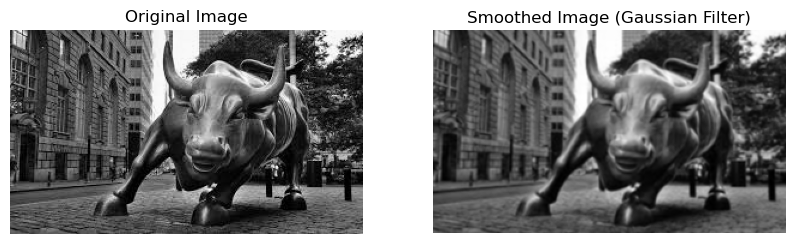

In [39]:
# step 1: Apply Gaussian smoothing on the image.
gaussian_kernel = (1/16) * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
gaussian_blur_custom = filtering_2d(img_matrix, gaussian_kernel)

plt.figure(figsize=(10, 5))
# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_matrix, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Smoothed image
plt.subplot(1, 2, 2)
plt.imshow(gaussian_blur_custom, cmap='gray')
plt.title('Smoothed Image (Gaussian Filter)')
plt.axis('off')
plt.savefig(f"{result_dir}/gaussian-blur.jpeg")
plt.show()

gradient_x [[346. 558. 118. ...   2.   4.  14.]
 [312. 645. 314. ...   4.  29.  60.]
 [333. 642. 389. ...  26.  29. 204.]
 ...
 [ 88. 112.  89. ...   6.   4.   1.]
 [ 16.  59.  93. ...  27.   2.   6.]
 [ 23.   2.  35. ...   8.  47.   5.]]
gradient_y [[ 34.  98. 224. ...   8.  22.  52.]
 [  0.  11. 146. ...  26.  43.  84.]
 [ 17.  46.  39. ...  28.  23.  80.]
 ...
 [310. 352. 307. ... 232. 180. 131.]
 [ 64. 147. 241. ...  65.  36.   6.]
 [ 59.  46.  25. ...  10.  45.  59.]]


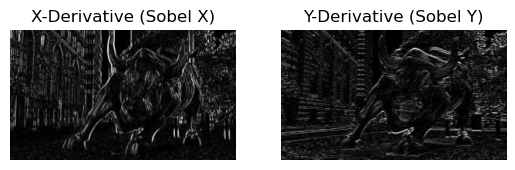

In [40]:
# step 2: Get X, and Y Derivatives using Sobel operator

kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

gradient_x = filtering_2d(img_matrix, kernel_x, True)
gradient_y = filtering_2d(img_matrix, kernel_y, True)

print("gradient_x", gradient_x)
print("gradient_y", gradient_y)

# X-derivative
plt.subplot(1, 2, 1)
plt.imshow(gradient_x, cmap="gray")
plt.title("X-Derivative (Sobel X)")
plt.axis("off")

# Y-derivative
plt.subplot(1, 2, 2)
plt.imshow(gradient_y, cmap="gray")
plt.title("Y-Derivative (Sobel Y)")
plt.axis("off")

plt.savefig(f"{result_dir}/x-and-y-derivatives.jpeg")
plt.show()

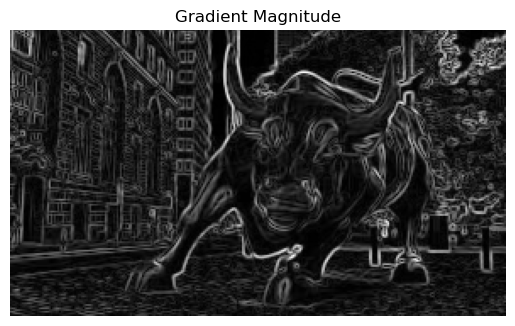

In [41]:
# step 3: compute gradient magnitude

gradient_magnitude = get_grad_mag(gradient_x, gradient_y)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')
plt.savefig(f"{result_dir}/gradient-magnitude.jpeg")
plt.show()


In [33]:
# step 4: compute gradient angle
gradient_angle = get_grad_mag(gradient_x, gradient_y)

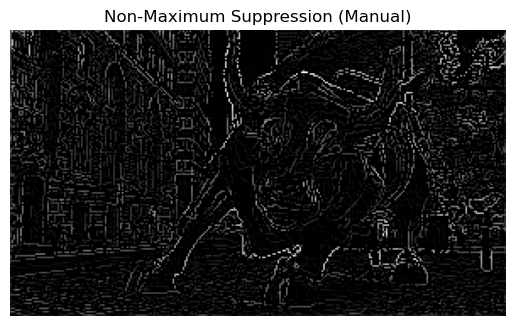

In [42]:
# step 5: Determine NMS (Non Maximum Suppression)
quantized_angles_array = quantized_angle(gradient_angle)

# Perform non-maximum suppression
nms_image = non_max_suppression(gradient_magnitude, quantized_angles_array)

# Normalize to 8-bit for display
nms_image_display = (nms_image / np.max(nms_image) * 255).astype(np.uint8)

# Plot the non-maximum suppressed image
plt.imshow(nms_image_display, cmap="gray")
plt.title("Non-Maximum Suppression (Manual)")
plt.axis("off")
plt.savefig(f"{result_dir}/nms.jpeg")
plt.show()

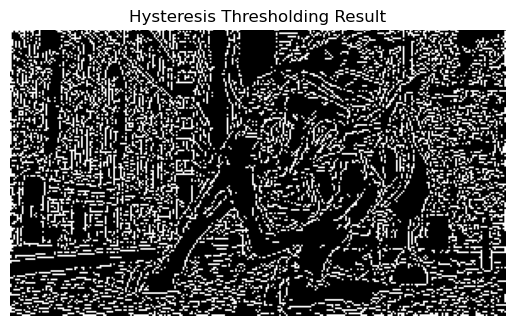

In [43]:
# Define low and high thresholds
low_threshold = 50
high_threshold = 100

# Apply hysteresis thresholding
hysteresis_image = hysteresis_thresholding(nms_image, low_threshold, high_threshold)

# Display the result
plt.imshow(hysteresis_image, cmap='gray')
plt.title('Hysteresis Thresholding Result')
plt.axis('off')

plt.savefig(f"{result_dir}/hysterisis-thresholding.jpeg")
plt.show()